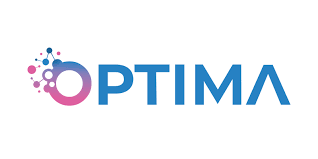
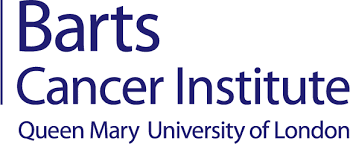


<div style="text-align: center; margin: 20px; background-color: #f9f9f9; padding: 20px; border-radius: 10px;">
    <h1 style="font-family: Arial, sans-serif; color: #333;">OPTIMA Prototyping Workshop, Berlin</h1>
    <a href="#" style="text-decoration: none; padding: 10px 20px; background-color: #4CAF50; color: white; border-radius: 5px; font-weight: bold; transition: background-color 0.3s;">
        November 6-8, 2024
    </a>
</div>


<h2 style="text-align: center; color: #2E3A4D;">Breast Lesion Classification in Mammograms Using Deep Learning</h2>

<div style="text-align: center; font-size: 1.1em; margin-bottom: 20px;">
    <strong>Centre for Biomarkers and Biotherapeutics</strong><br>
    <strong>Barts Cancer Institute, Queen Mary University of London, UK</strong>
</div>



<div style="text-align: center; font-size: 1.1em; background-color: #f4f4f4; padding: 15px; border-radius: 8px;">
    <p><strong>Author:</strong> Dr. Vivek Kumar Singh (Group Leader in AI & Imaging)</p>
    <p><strong>Copyright:</strong> 2024, Lesion classification</p>
    <p><strong>Maintainer:</strong> Dr. Vivek Kumar Singh</p>
    <p><strong>Credits:</strong> Dr. Vivek Kumar Singh</p>
    <p><strong>Email:</strong> <a href="mailto:vivek.singh@qmul.ac.uk" style="color: #007BFF; text-decoration: none;">vivek.singh@qmul.ac.uk</a></p>
    <p><strong>Status:</strong> Development</p>
</div>


## Overview
This Jupyter notebook describes a process to classify breast lesions as **benign or malignant** using deep learning on mammogram images.

## Dataset
- The dataset can be accessed here: [Cancer Imaging Archive - CMMD Collection](https://www.cancerimagingarchive.net/collection/cmmd/)

## Pipeline Steps

1. **Import Libraries:** Load essential libraries like PyTorch, NumPy, and Matplotlib.

2. **Data Preparation:**
   - **Load Dataset:** Load mammogram images and their labels.
   - **Data Augmentation:** Use techniques like rotation and flipping to enhance the dataset.
   - **Data Splitting:** Divide the dataset into training, validation, and test sets.

3. **Model Development:**
   - **Model Architecture:** Define a Convolutional Neural Network (CNN).
   - **Loss Function and Optimizer:** Use CrossEntropyLoss and Adam optimizer.

4. **Model Training:** Train the model on the training set and record validation metrics.

5. **Model Evaluation:**
   - **Testing:** Assess the model's performance on the test set.
   - **Visualizations:** Create a confusion matrix and ROC curve to evaluate performance.

6. **Results Visualization:** Provide plots of accuracy, loss, confusion matrix, and ROC curves for analysis.

7. **Conclusion:** Summarize findings and insights on the model's effectiveness in classifying breast lesions.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Importing Necessary Libraries

- **Start by importing libraries required for the project**:
  - **PyTorch**: Main framework for building and training deep learning models.

  - **Visualization Libraries**:
    - Enable plotting of data distributions, model performance metrics, and other insights.

- **Benefits of Importing Libraries Early**:
  - Streamlines workflow.
  - Reduces interruptions during critical development phases.

In [2]:
import os
import shutil
import random
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time, copy, argparse
import multiprocessing
from torchsummary import summary
from matplotlib import pyplot as plt
import timm
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score
import cv2
from sklearn.manifold import TSNE

# Data split into training, validation and testing
The dataset is divided into three distinct subsets: training, validation, and testing. This approach is essential to ensure that the model is trained effectively and evaluated in a robust manner.

- **Training Set**
  - **Purpose**: Used to train the model by identifying patterns and adjusting parameters.
  - **Process**: Model learns relationships within the data through optimization of loss functions.


- **Validation Set**
  - **Purpose**: Fine-tunes model hyperparameters (e.g., learning rate, batch size).
  - **Process**: Evaluates model performance after each epoch, helping to prevent overfitting by ensuring the model doesn't become overly specialized to the training data.


- **Testing Set**
  - **Purpose**: Final evaluation on unseen data to measure generalization.
  - **Process**: Provides an unbiased estimate of model performance on real-world data, confirming its accuracy on new predictions.

**Why This Split Matters**: Ensures the model is well-trained, fine-tuned, and rigorously tested, allowing it to generalize and make accurate predictions on future data.

In [3]:
import os
import random
import shutil
from collections import defaultdict

def split_dataset(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Ratios must sum to 1"

    # Check if split folders and subfolders already exist
    split_folders_exist = all(
        os.path.exists(os.path.join(dest_dir, split, class_name))
        for split in ['train', 'val', 'test']
        for class_name in ['benign', 'malignant']
    )

    if split_folders_exist:
        print("Warning: Split folders and subfolders already exist. Skipping dataset split.")
        return

    # Create destination directory if it doesn't exist
    os.makedirs(dest_dir, exist_ok=True)

    # Create destination directories for each split and class
    for split in ['train', 'val', 'test']:
        for class_name in ['benign', 'malignant']:
            os.makedirs(os.path.join(dest_dir, split, class_name), exist_ok=True)

    # Group images by patient
    patient_images = defaultdict(list)
    for class_name in ['benign', 'malignant']:
        class_dir = os.path.join(source_dir, class_name)
        for img in os.listdir(class_dir):
            patient_id = img.split('_')[1]  # Assuming format ROI_D1-00xx_xxx
            patient_images[patient_id].append((class_name, img))

    # Split patients into train, val, and test
    patients = list(patient_images.keys())
    random.shuffle(patients)

    n_train = int(len(patients) * train_ratio)
    n_val = int(len(patients) * val_ratio)

    train_patients = patients[:n_train]
    val_patients = patients[n_train:n_train+n_val]
    test_patients = patients[n_train+n_val:]

    # Copy images to respective directories
    for split, split_patients in [('train', train_patients),
                                  ('val', val_patients),
                                  ('test', test_patients)]:
        for patient in split_patients:
            for class_name, img in patient_images[patient]:
                src = os.path.join(source_dir, class_name, img)
                dst = os.path.join(dest_dir, split, class_name, img)
                shutil.copy(src, dst)

    # Print statistics
    print(f"Train set: {len(train_patients)} patients")
    print(f"Validation set: {len(val_patients)} patients")
    print(f"Test set: {len(test_patients)} patients")

# Organizing the Dataset for Training, Validation, and Testing with Class Subfolders

1. **Define a Root Folder**:
   - Create a main directory (e.g., `dataset_root`) where all split images will be stored.

2. **Create Subfolders for Each Split**:
   - Inside the root folder, create three subdirectories:
     - `train`: Stores images for training the model.
     - `validation`: Contains images for fine-tuning the model’s hyperparameters.
     - `test`: Holds images reserved for final evaluation of the model.

3. **Create Class Subfolders Within Each Split**:
   - In each of the `train`, `validation`, and `test` subdirectories, create two subfolders:
     - `benign`: Stores images labeled as benign.
     - `malignant`: Stores images labeled as malignant.

4. **Save Split Images in Class Folders**:
   - After splitting the dataset, save each image in its corresponding class folder within the appropriate split folder to ensure organization and accessibility.

**Example Directory Structure**:
```plaintext
dataset_root/
├── train/
│   ├── benign/
│   │   ├── image1.png
│   │   ├── image2.png
│   │   └── ...
│   └── malignant/
│       ├── image1.png
│       ├── image2.png
│       └── ...
├── validation/
│   ├── benign/
│   │   ├── image1.png
│   │   ├── image2.png
│   │   └── ...
│   └── malignant/
│       ├── image1.png
│       ├── image2.png
│       └── ...
└── test/
    ├── benign/
    │   ├── image1.png
    │   ├── image2.png
    │   └── ...
    └── malignant/
        ├── image1.png
        ├── image2.png
        └── ...



In [4]:
root = "/content/gdrive/MyDrive/Workshop-Nov24/Phase_I/"

source_directory = os.path.join(root,'CMMD_dataset', 'ROI')
destination_directory = os.path.join(root,'CMMD_dataset', 'ROI', 'split')
split_dataset(source_directory, destination_directory)

# Setting Up Directory Paths for Training, Validation, and Checkpoints

- **Define Paths**:
  - **train_directory** and **valid_directory**: Paths for the training and validation datasets. Use `os.path.join` to ensure compatibility across operating systems.
  - **checkpoint_directory**: Path to save model checkpoints. The command `os.makedirs(checkpoint_directory, exist_ok=True)` creates the directory if it doesn’t exist.

- **Model Save Path**:
  - **model_save_path**: Sets the location for saving model weights or checkpoints (e.g., `model.pth`).

- **Confirmation**:
  - After running this setup, the paths for training, validation, and checkpoint directories will be displayed to confirm they are correctly set.


In [5]:
# Set the train and validation directory paths

train_directory = os.path.join(destination_directory, 'train')
valid_directory = os.path.join(destination_directory, 'val')

# Set the checkpoint directory path
checkpoint_directory = os.path.join(root, 'checkpoint')

# Create the checkpoint directory if it doesn't exist
os.makedirs(checkpoint_directory, exist_ok=True)

# Now you can set your model save path
model_save_path = os.path.join(checkpoint_directory, 'model.pth')

print(f"Checkpoint directory created at: {checkpoint_directory}")
print(f"Model will be saved at: {model_save_path}")

Checkpoint directory created at: /content/gdrive/MyDrive/Workshop-Nov24/Phase_I/checkpoint
Model will be saved at: /content/gdrive/MyDrive/Workshop-Nov24/Phase_I/checkpoint/model.pth


# Model hyperparameters

Key hyperparameters define the training behavior, affecting model performance, speed, and accuracy:

- **Batch Size (bs)**:
  - Determines the number of samples processed before updating weights.
  - Smaller batch sizes (e.g., 32) lead to more frequent updates, while larger ones make better use of GPU memory but may affect convergence.

- **Number of Epochs (num_epochs)**:
  - Defines the total passes through the dataset.
  - Higher values provide more learning opportunities but risk overfitting if too high.

- **Number of Classes (num_classes)**:
  - Total output categories to predict (e.g., 2 for binary classification like benign vs. malignant).


- **Return Preactivation (RETURN_PREACTIVATION)**:
  - Determines if the model outputs pre-activation values (default: `False`).
  - Useful for specific analyses but typically unnecessary for general training.


In [6]:
# Batch size
bs = 32
# Number of epochs
num_epochs = 5
# Number of classes
num_classes = 2

RETURN_PREACTIVATION = False

# Apply Transformations to the Data

Define data augmentation and normalization techniques to enhance model generalization:

- **Data Augmentation** (for training data):
  - Introduces variations in the images, helping the model generalize better.
  - Common techniques include random rotations, flips, and scaling.

- **Tensor**:

    - `transforms.ToTensor()` is a transformation provided by the PyTorch library, specifically within the `torchvision.transforms` module.
    - Converts a PIL Image or a NumPy ndarray (representing an image) into a PyTorch tensor, which is required for model training and inference.

- **Normalization**:
  - Adjusts pixel values to a consistent range, aiding model stability and performance.


In [7]:
# Applying transforms to the data
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=256),
        transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(),
        # transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Load Images Using ImageFolder

In this step, we utilize the `ImageFolder` class from `torchvision.datasets` to efficiently load images from the defined directories:

- **Training Dataset**:
  - Loaded from `train_directory`.
  - Applies training-specific transformations (e.g., data augmentation).

- **Validation Dataset**:
  - Loaded from `valid_directory`.
  - Applies validation-specific transformations (e.g., normalization).

This approach allows PyTorch to automatically categorize images based on the folder structure, with each subfolder representing a class, streamlining the data loading process for training and validation.


In [8]:
# Load data from folders
dataset = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])
}

# Dataset Sizes and Data Loaders

- **Calculating Dataset Sizes**:
  - Use `len()` to compute the number of images in both the training and validation datasets.
  - Provides an overview of the available data for each phase.

- **Creating Data Loaders**:
  - Utilize `DataLoader` from `torch.utils.data` for both training and validation datasets.
  - Handles batching, shuffling, and multi-threaded loading to efficiently supply data to the model.

### Data Loader Parameters:
- **Batch Size (bs)**:
  - Controls the number of samples processed per iteration.
  
- **Shuffling**:
  - Randomly shuffles data at each epoch to improve model robustness.

- **Number of Workers (num_cpu)**:
  - Sets the number of CPU threads for data loading, enhancing efficiency.

- **Pin Memory**:
  - Speeds up data transfer to the GPU, improving training performance.

- **Drop Last**:
  - Discards the last incomplete batch if the dataset size isn’t divisible by the batch size.



In [9]:
# Size of train and validation data
dataset_sizes = {
    'train':len(dataset['train']),
    'valid':len(dataset['valid'])
}

# Create iterators for data loading
dataloaders = {
    'train':data.DataLoader(dataset['train'], batch_size=bs, shuffle=True,
                            num_workers=0, pin_memory=True, drop_last=True),
    'valid':data.DataLoader(dataset['valid'], batch_size=bs, shuffle=True,
                            num_workers=0, pin_memory=True, drop_last=True)
}

# Display Sample Images

In this section, we visualize a selection of sample images from the training dataset to ensure correct loading and transformation application. This step aids in understanding the data's distribution and quality.

- **Purpose**:
  - Confirm that images are loaded correctly.
  - Validate the application of transformations.
  - Provide insights into the dataset's distribution and quality.

- **Visualization Tool**:
  - Typically utilize `matplotlib` for image display.
  
- **Display Format**:
  - Retrieve images from the training data loader.
  - Plot images in a grid format for easier comparison.

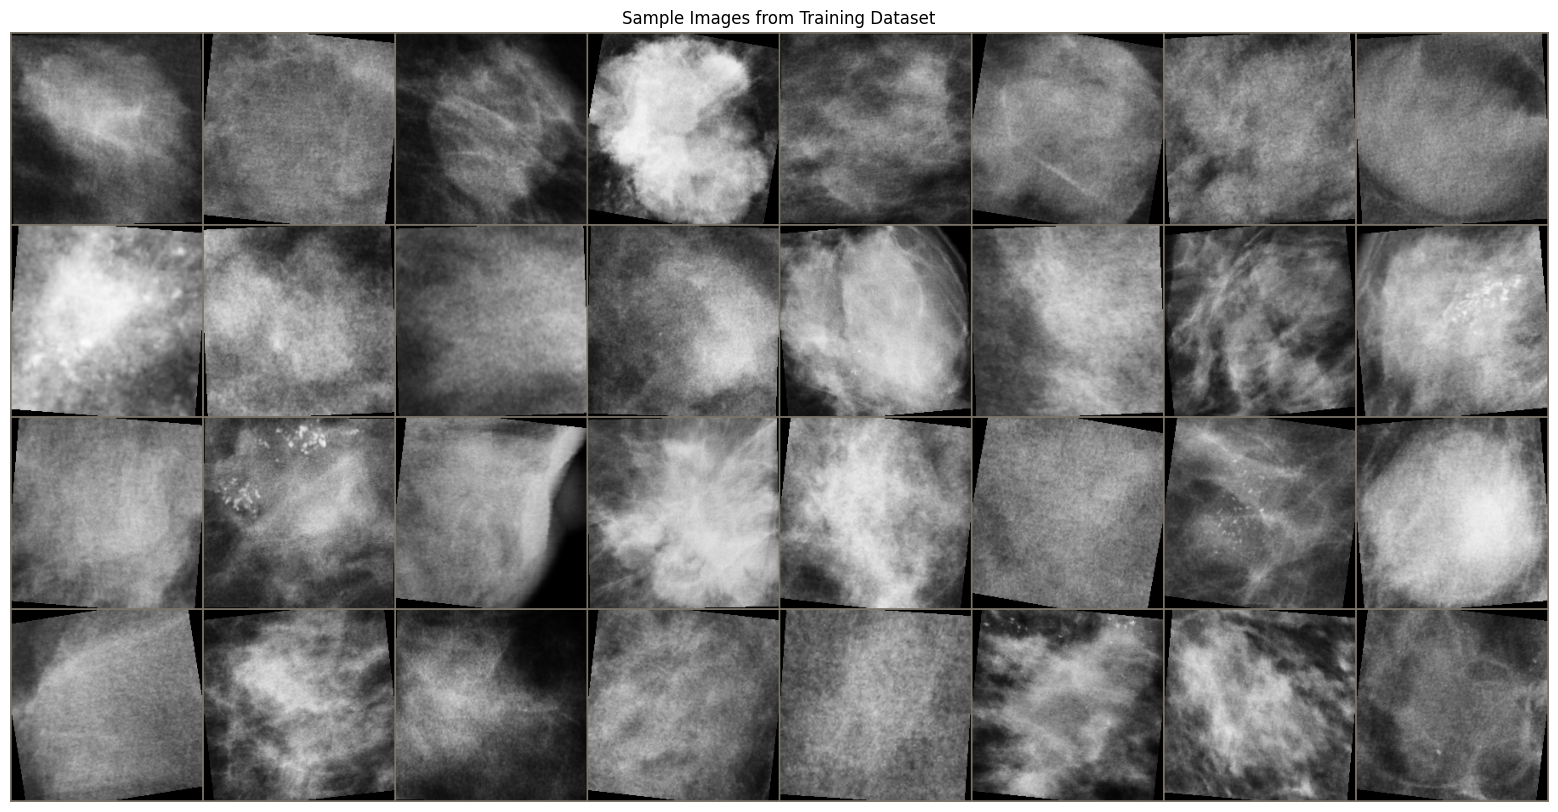

Labels: tensor([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0])


In [10]:
# Function to denormalize images
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    return tensor * std + mean

# Get a batch of training data
inputs, labels = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot images
plt.figure(figsize=(20, 10))
plt.imshow(denormalize(out).squeeze(0).permute(1, 2, 0))  # Add squeeze(0) before permute
plt.axis('off')
plt.title('Sample Images from Training Dataset')
plt.show()

# Print labels
print('Labels:', labels)

# Class Names or Target Labels

In this section, we retrieve and display the class names (target labels) from the training dataset. These class names correspond to the subfolder names in the `train_directory`, helping to identify the different categories of images used for training and validation.

- **Retrieve Class Names**:
  - Extract class names from the subfolder structure in the `train_directory`.

- **Print Dataset Sizes**:
  - Display the sizes of both the training and validation datasets.
  - Provides an overview of data distribution, which is crucial for understanding the dataset scale and ensuring it meets the training model's requirements.

In [11]:
# Class names or target labels
class_names = dataset['train'].classes
print("Classes:", class_names)

# Print the train and validation data sizes
print("Training-set size:",dataset_sizes['train'],
      "\nValidation-set size:", dataset_sizes['valid'])

Classes: ['benign', 'malignant']
Training-set size: 764 
Validation-set size: 160


# Set Default Device as GPU, If Available

In this section, we check for GPU availability for computation and set the device accordingly. Utilizing a GPU can significantly enhance the speed of training and inference processes in deep learning models.

- **Device Check**:
  - Determine if a GPU is available using PyTorch's built-in functionality.
  
- **Set Device**:
  - If a GPU is available, set the device to GPU.
  - If no GPU is found, fall back to using the CPU.


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Loading a Pretrained Model for Fine-Tuning

In this section, we load the ResNet-50 model pretrained on ImageNet, allowing us to leverage learned features from a large dataset. This approach can significantly enhance performance, especially with limited training data.

- **Loading the Model**:
  - Utilize `torchvision.models` to load the ResNet-50 architecture.
  - Set `pretrained=True` to initialize the model with weights learned from the ImageNet dataset.

- **Modifying the Final Layer**:
  - If `RETURN_PREACTIVATION` is set to True:
    - Remove the final fully connected layer to output features directly, useful for specific tasks.
  - Otherwise:
    - Replace the final layer with a new fully connected layer matching the number of output features to the number of classes in our dataset.

- **Transferring the Model to GPU**:
  - Move the model to the GPU (if available) using the previously set device.
  - This enables efficient use of the GPU's computational power during training.

By loading and modifying a pretrained model, we can effectively adapt it to our specific classification task.


In [13]:
print("\nLoading resnet50 for finetuning ...\n")

model = torchvision.models.__dict__['resnet50'](pretrained=True)
if RETURN_PREACTIVATION:
    model.fc = torch.nn.Sequential()
else:
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model_ft = model.cuda()

# Transfer the model to GPU
model_ft = model_ft.to(device)


Loading resnet50 for finetuning ...



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


# Printing the Model Summary

In this section, we print a summary of the model, providing insights into its architecture, layer details, parameters, and gradient requirements for training.

- **Enumerating Model Parameters**:
  - Iterate over the model's named parameters using `model.named_parameters()`.
  - This provides parameter names along with their corresponding tensors.
  - The `requires_grad` attribute indicates whether the parameter will be updated during training (i.e., if gradients will be computed for it).

- **Using the Summary Function**:
  - The `summary` function from `torchsummary` offers a comprehensive overview of the model architecture.
  - Displays information such as:
    - Output shape of each layer
    - Number of parameters per layer
    - Total number of trainable parameters in the model
  - The `input_size` argument specifies the shape of the input images that the model expects.


In [14]:
# Print model summary
print('Model Summary:-\n')
for num, (name, param) in enumerate(model_ft.named_parameters()):
    print(num, name, param.requires_grad )
summary(model_ft, input_size=(3, 224, 224))
# print(model_ft)

Model Summary:-

0 conv1.weight True
1 bn1.weight True
2 bn1.bias True
3 layer1.0.conv1.weight True
4 layer1.0.bn1.weight True
5 layer1.0.bn1.bias True
6 layer1.0.conv2.weight True
7 layer1.0.bn2.weight True
8 layer1.0.bn2.bias True
9 layer1.0.conv3.weight True
10 layer1.0.bn3.weight True
11 layer1.0.bn3.bias True
12 layer1.0.downsample.0.weight True
13 layer1.0.downsample.1.weight True
14 layer1.0.downsample.1.bias True
15 layer1.1.conv1.weight True
16 layer1.1.bn1.weight True
17 layer1.1.bn1.bias True
18 layer1.1.conv2.weight True
19 layer1.1.bn2.weight True
20 layer1.1.bn2.bias True
21 layer1.1.conv3.weight True
22 layer1.1.bn3.weight True
23 layer1.1.bn3.bias True
24 layer1.2.conv1.weight True
25 layer1.2.bn1.weight True
26 layer1.2.bn1.bias True
27 layer1.2.conv2.weight True
28 layer1.2.bn2.weight True
29 layer1.2.bn2.bias True
30 layer1.2.conv3.weight True
31 layer1.2.bn3.weight True
32 layer1.2.bn3.bias True
33 layer2.0.conv1.weight True
34 layer2.0.bn1.weight True
35 layer2.0.b

# Defining the Loss Function

In this section, we define the loss function used to evaluate the model's performance during training.

- **Loss Function**:
  - We use `nn.CrossEntropyLoss()`, which is standard for multi-class classification problems.
  - This loss function combines `LogSoftmax` and `NLLLoss` into a single class.
  - It is designed to work with raw, unnormalized scores (logits) from the model, making it well-suited for our use case with multiple classes to predict.

- **Purpose**:
  - The cross-entropy loss measures the difference between predicted probabilities (after applying softmax) and actual class labels.
  - During training, the model aims to minimize this loss, leading to improved accuracy in the classification task.

Defining an appropriate loss function is crucial for guiding the model's learning process and achieving better performance on the task.


In [15]:
criterion = nn.CrossEntropyLoss()

# Defining the Optimizer

In this section, we define the optimizer used to update the model parameters during training.

- **Optimizer Selection**:
  - We use `optim.SGD`, which stands for Stochastic Gradient Descent.
  - It is a widely-used optimization algorithm that updates model parameters based on gradients computed from the loss function.

- **Model Parameters**:
  - `model_ft.parameters()` retrieves all the parameters of the model that need to be optimized.

- **Learning Rate (lr)**:
  - Set to 0.01, it controls how much to adjust the model parameters in response to estimated gradients.
  - A smaller learning rate promotes stable convergence, while a larger one may speed up training but risks overshooting optimal values.

- **Momentum**:
  - Set to 0.9, momentum helps accelerate SGD in the relevant direction and dampens oscillations.
  - It keeps track of past gradients to smooth out updates, facilitating faster convergence.


In [16]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Defining the Learning Rate Scheduler

In this section, we define a learning rate scheduler to adjust the learning rate during training.

- **Scheduler Selection**:
  - We use `lr_scheduler.StepLR`, which reduces the learning rate by a specified factor after a set number of epochs.
  - This approach can enhance convergence, especially in the later stages of training.

- **Optimizer**:
  - `optimizer_ft` is passed to the scheduler, enabling it to adjust the learning rate used by this optimizer.

- **Step Size (step_size)**:
  - Set to 25, indicating that the learning rate will be decreased every 25 epochs.
  - This helps stabilize the model as it approaches convergence.

- **Decay Factor (gamma)**:
  - Set to 0.1, which specifies that the learning rate will be multiplied by 0.1 after each step.
  - This reduction allows for more refined updates to the model parameters as training progresses.

In [17]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

# Model Training Routine

In this section, we define a function `train_model` that orchestrates the training and validation process for the deep learning model.

## Function Definition
- **Parameters**:
  1. **model**: The neural network model to be trained.
  2. **criterion**: The loss function used to evaluate the model's performance.
  3. **optimizer**: The optimization algorithm to update the model's parameters.
  4. **scheduler**: The learning rate scheduler to adjust the learning rate during training.
  5. **num_epochs**: The total number of epochs for training.

## Initialization
- Initialize best model weights and best accuracy for comparison.
- Create a TensorBoard `SummaryWriter` to log training metrics.

## Training Loop
- Iterate through each epoch, alternating between training and validation phases.
- Set model to training mode (`model.train()`) for training and evaluation mode (`model.eval()`) for validation.

## Data Iteration
- Iterate through the data using the dataloaders.
- Move inputs and labels to the appropriate device (CPU or GPU).
- Zero optimizer gradients to prevent accumulation from previous iterations.

## Forward Pass
- Generate predictions with a forward pass.
- Compute loss using the specified criterion.
- In training mode, perform backpropagation (`loss.backward()`) and update model parameters (`optimizer.step()`).

## Loss and Accuracy Calculation
- Accumulate running loss and correct predictions to calculate epoch loss and accuracy.
- Log training and validation metrics using TensorBoard for visual representation.

## Best Model Checkpointing
- Save model weights if the validation accuracy exceeds the best recorded accuracy.

## Completion and Return
- Print total training time and best validation accuracy achieved.
- Load and return the best model weights for further use.


In [18]:
import time
import copy
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Model training routine
print("\nTraining:-\n")
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store loss and accuracy values
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []

    # Tensorboard summary
    writer = SummaryWriter()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Record training loss and accuracy for each phase
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
                writer.add_scalar('Train/Loss', epoch_loss, epoch)
                writer.add_scalar('Train/Accuracy', epoch_acc, epoch)
            else:
                valid_losses.append(epoch_loss)
                valid_accs.append(epoch_acc.item())
                writer.add_scalar('Valid/Loss', epoch_loss, epoch)
                writer.add_scalar('Valid/Accuracy', epoch_acc, epoch)

            # Deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Plotting the training and validation loss and accuracy
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), valid_losses, label='Valid Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accs, label='Train Accuracy')
    plt.plot(range(num_epochs), valid_accs, label='Valid Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.show()

    return model



Training:-



# Train the model

Epoch 0/4
----------
train Loss: 0.6539 Acc: 0.5353
valid Loss: 0.6291 Acc: 0.6313

Epoch 1/4
----------
train Loss: 0.5979 Acc: 0.6243
valid Loss: 0.6066 Acc: 0.6313

Epoch 2/4
----------
train Loss: 0.5759 Acc: 0.6322
valid Loss: 0.5712 Acc: 0.7063

Epoch 3/4
----------
train Loss: 0.5882 Acc: 0.6492
valid Loss: 0.6666 Acc: 0.6063

Epoch 4/4
----------
train Loss: 0.5754 Acc: 0.6361
valid Loss: 0.5842 Acc: 0.6875

Training complete in 8m 35s
Best val Acc: 0.706250


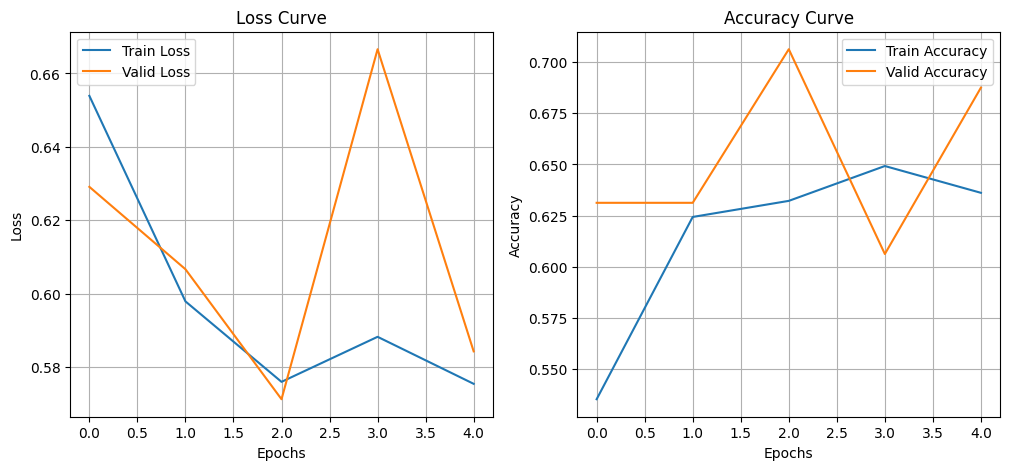


Saving the model...


In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)
# Save the entire model
print("\nSaving the model...")
torch.save(model_ft, model_save_path)

# Paths for Evaluation Image Directory and Model Checkpoint

In this section, we define the paths used for loading evaluation images and saving the model checkpoints during the training process.

## Evaluation Image Directory
- **Path**: Specify the directory where the evaluation images are stored.



In [20]:
EVAL_DIR = os.path.join(destination_directory, 'test')
EVAL_MODEL= model_save_path
print(EVAL_DIR)

/content/gdrive/MyDrive/Workshop-Nov24/Phase_I/CMMD_dataset/ROI/split/test


# Load the Model for Evaluation

In [21]:
model = torch.load(EVAL_MODEL)
model.eval()

<ipython-input-21-91622fce400e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(EVAL_MODEL)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Configure batch size

In [22]:
bs = 8

# Prepare the eval data loader

In [23]:
eval_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])])

eval_dataset = datasets.ImageFolder(root=EVAL_DIR, transform=eval_transform)
eval_loader = data.DataLoader(eval_dataset, batch_size=bs, shuffle=True,
                              num_workers=0, pin_memory=True)

# Enable GPU mode, if CUDA is available

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Number of classes and dataset size

In [25]:
num_classes = len(eval_dataset.classes)
dsize = len(eval_dataset)

# Class label names

In [26]:
class_names = ['Benign', 'Malignant']

# Initialize the Prediction and Label Lists

In this section, we prepare lists to store the predictions made by the model and the corresponding true labels from the evaluation dataset. This setup is crucial for evaluating the model's performance by comparing the predicted classes with the actual classes.

## Steps to Initialize Lists

1. **Create Empty Lists:**
   - We will create two empty lists: one for storing the predicted labels and another for storing the true labels.

   ```python
   predictions = []
   true_labels = []


In [27]:
predlist = torch.zeros(0, dtype=torch.long, device='cpu')
lbllist = torch.zeros(0, dtype=torch.long, device='cpu')

# Initilizations

In [28]:
correct = 0
total = 0
predlist = torch.tensor([])  # to store the predicted labels
lbllist = torch.tensor([])   # to store the true labels
all_probs = torch.tensor([])  # to store probabilities for ROC curve

# Model Evaluation Mode

In this section, we set the model to evaluation mode, which is essential for performing inference on the evaluation dataset. Switching to evaluation mode adjusts the behavior of certain layers in the model, such as dropout and batch normalization, ensuring that they function appropriately during evaluation.

## Setting the Model to Evaluation Mode

1. **Switching Mode:**
   - The model's mode is changed to evaluation by calling the `.eval()` method. This informs the model that it is in inference mode, which is crucial for getting accurate predictions.


In [29]:
model.eval()  # Ensure the model is in evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Evaluate the model accuracy on the test dataset

In [30]:
with torch.no_grad():
    for images, labels in eval_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Get probabilities using softmax
        probs = torch.softmax(outputs, dim=1)
        all_probs = torch.cat([all_probs, probs.cpu()])

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        predlist = torch.cat([predlist, predicted.view(-1).cpu()])
        lbllist = torch.cat([lbllist, labels.view(-1).cpu()])

# Convert lbllist and predlist to integers for bincount
lbllist = lbllist.to(torch.int64)
predlist = predlist.to(torch.int64)

# Overall accuracy
overall_accuracy = 100 * correct / total
print('Accuracy of the network on the {:d} test images: {:.2f}%'.format(total, overall_accuracy))

Accuracy of the network on the 166 test images: 57.23%


# Plotting

Confusion Matrix
----------------
[[36 45]
 [26 59]] 



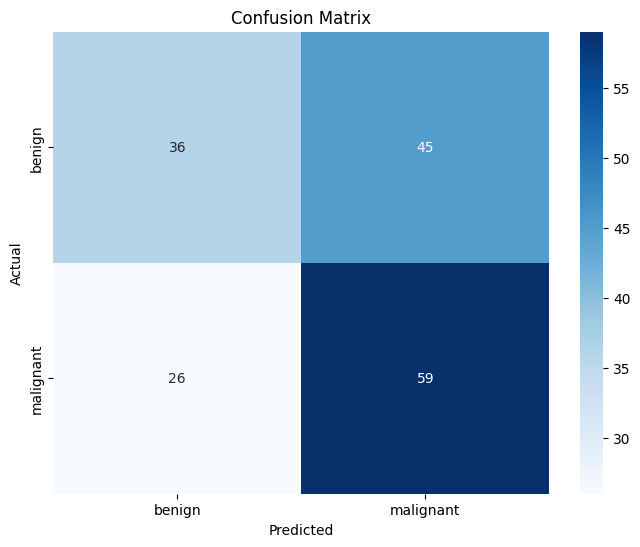

Shape of lbllist_one_hot: (166, 2)
Shape of all_probs: torch.Size([166, 2])
Class benign: AUC = 0.61
Class malignant: AUC = 0.61


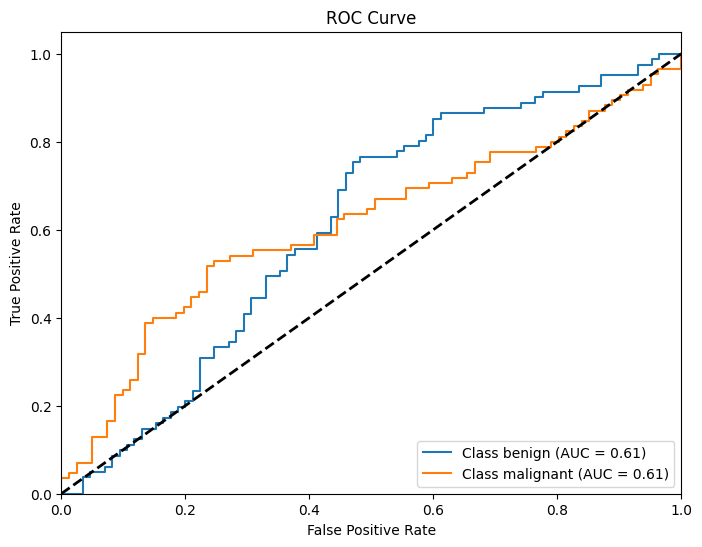

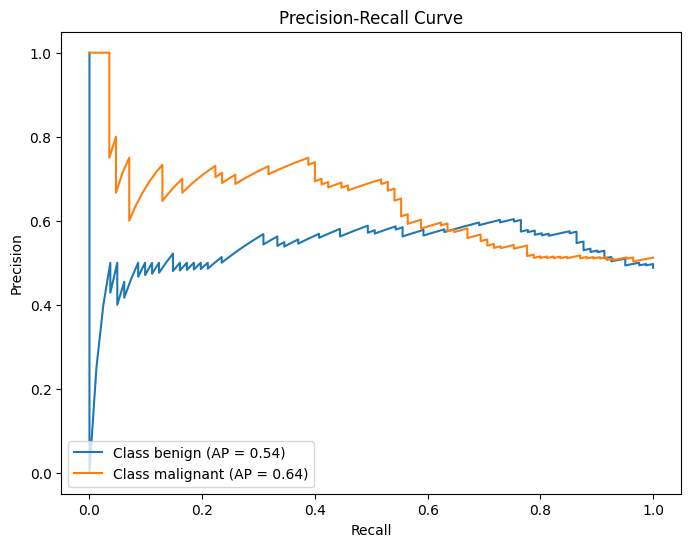

In [31]:
# Confusion Matrix
n_classes = len(eval_dataset.classes)
conf_mat = confusion_matrix(lbllist.numpy(), predlist.numpy(), labels=np.arange(n_classes))  # Ensure all classes are included
print('Confusion Matrix')
print('-'*16)
print(conf_mat,'\n')

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=eval_dataset.classes,
            yticklabels=eval_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
lbllist_one_hot = np.eye(n_classes)[lbllist.numpy()]  # One-hot encode the labels
fpr = {}
tpr = {}
roc_auc = {}

# Check the shapes of lbllist_one_hot and all_probs
print("Shape of lbllist_one_hot:", lbllist_one_hot.shape)
print("Shape of all_probs:", all_probs.shape)

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(lbllist_one_hot[:, i], all_probs[:, i].numpy())
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f"Class {eval_dataset.classes[i]}: AUC = {roc_auc[i]:.2f}")

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {eval_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve and Average Precision
precision = {}
recall = {}
avg_precision = {}

# Compute Precision-Recall curve and Average Precision for each class
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(lbllist_one_hot[:, i], all_probs[:, i].numpy())
    avg_precision[i] = average_precision_score(lbllist_one_hot[:, i], all_probs[:, i].numpy())

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f"Class {eval_dataset.classes[i]} (AP = {avg_precision[i]:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


# Hook to Extract Gradients and Feature Maps

In this section, we define a hook mechanism that allows us to capture gradients and feature maps from specific layers of the neural network. Hooks provide a powerful way to observe and analyze the inner workings of the model during both the forward and backward passes.

## What Are Hooks?

- **Definition:** Hooks are functions that can be registered to layers or operations within the neural network. They can be triggered during the forward or backward pass of the network, allowing us to access intermediate outputs or gradients.

## Purpose of Using Hooks

1. **Extract Feature Maps:**
   - By attaching a hook to a specific layer, we can capture the output (feature map) of that layer during the forward pass. This enables us to visualize what features are being detected by the model at different stages of processing.

2. **Capture Gradients:**
   - Hooks can also be used to extract gradients during the backward pass. This allows us to analyze how the loss is influencing the parameters of different layers and understand the importance of specific features.

In [33]:
class SaveFeatures:
    def __init__(self, module):
        self.module = module
        self.features = None
        self.gradients = None
        self.hook = module.register_forward_hook(self.hook_fn)
        self.hook_grad = module.register_backward_hook(self.hook_grad_fn)

    def hook_fn(self, module, input, output):
        self.features = output

    def hook_grad_fn(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  # Gradient with respect to the output

    def close(self):
        self.hook.remove()
        self.hook_grad.remove()

class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.model.eval()

    def __call__(self, x, class_idx=None):
        conv_output = SaveFeatures(self.target_layer)  # Hook to get feature maps and gradients
        model_output = self.model(x)

        if class_idx is None:
            class_idx = torch.argmax(model_output)  # Default to the class with the highest score

        one_hot = torch.zeros((1, model_output.size()[-1]), dtype=torch.float32).to(x.device)
        one_hot[0][class_idx] = 1

        self.model.zero_grad()
        model_output.backward(gradient=one_hot, retain_graph=True)  # Backpropagate for the target class

        # Get the gradients and feature maps from the hook
        gradients = conv_output.gradients
        feature_maps = conv_output.features[0]

        # Perform global average pooling to get the weights
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # Multiply feature maps by the pooled gradients
        for i in range(len(pooled_gradients)):
            feature_maps[i, :, :] *= pooled_gradients[i]

        # Average along the channel dimension to get the Grad-CAM heatmap
        heatmap = torch.mean(feature_maps, dim=0).cpu().detach().numpy()

        # Apply ReLU
        heatmap = np.maximum(heatmap, 0)

        # Normalize the heatmap
        heatmap /= np.max(heatmap)
        return heatmap

# Function to overlay Grad-CAM heatmap on the image
def overlay_heatmap(heatmap, img):
    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to uint8 format
    heatmap = np.uint8(255 * heatmap)

    # Apply color map (e.g., JET) to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert the original image to uint8 (if it's float32)
    if img.dtype != np.uint8:
        img = np.uint8(255 * img)

    # Ensure the original image has 3 channels (if it's grayscale, convert to RGB)
    if len(img.shape) == 2 or img.shape[2] == 1:  # If grayscale
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Overlay the heatmap onto the original image
    overlayed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return overlayed_img

# Load your test image and preprocess
def preprocess_image(image_path, transform):
    image = cv2.imread(image_path, 1)
    image = np.float32(cv2.resize(image, (224, 224))) / 255
    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return img_tensor, image

# Function to process all images in a folder
def process_images_in_folder(folder_path, transform, model, target_layer):
    grad_cam = GradCam(model, target_layer)

    # Create a results folder if it doesn't exist
    results_folder = os.path.join(root, 'gradcam_results')
    os.makedirs(results_folder, exist_ok=True)

    # Iterate through all images in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):  # Add other formats if necessary
            image_path = os.path.join(folder_path, filename)
            image_tensor, original_img = preprocess_image(image_path, transform)

            # Run Grad-CAM
            heatmap = grad_cam(image_tensor.to(device))
            overlayed_image = overlay_heatmap(heatmap, original_img)

            # Save the overlayed image
            result_path = os.path.join(results_folder, f'gradcam_{filename}')
            cv2.imwrite(result_path, overlayed_image)

            # Optional: Display the result
            plt.figure(figsize=(8, 8))
            plt.subplot(1, 2, 1)
            plt.imshow(original_img)
            plt.title('Original Image')

            plt.subplot(1, 2, 2)
            plt.imshow(overlayed_image)
            plt.title('Grad-CAM Heatmap')
            plt.show()

# Example usage of Grad-CAM on all images in a folder
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

# Replace with the layer you want to visualize (e.g., last conv layer in ResNet)
target_layer = model.layer4[-1]  # Last convolutional layer in ResNet

# Specify the folder containing the test images
folder_path = EVAL_DIR + '/benign' # Adjust as necessary
print(folder_path)

# Process all images in the specified folder
process_images_in_folder(folder_path, transform, model, target_layer)

/content/gdrive/MyDrive/Workshop-Nov24/Phase_I/CMMD_dataset/ROI/split/test/benign


# Function to Extract Features from a Target Layer

In this section, we define a function specifically designed to extract feature maps from a designated layer of the neural network. This functionality allows us to analyze the representations learned at various stages of the network and provides insights into how the model interprets input data.

## Purpose:

The primary goal of this function is to capture the output (feature map) from a particular layer during the forward pass of the model. This is particularly valuable for:

1. **Visualizing Learned Representations:**
   - By examining feature maps, we can observe how different types of features are detected by the model. For example, we can identify low-level features such as edges and textures in the early layers, and higher-level features like objects and shapes in the deeper layers.

2. **Understanding Network Processing:**
   - Analyzing feature maps helps us understand how the network processes input data at various depths, revealing the hierarchy of features the model learns throughout training.

In [34]:
def extract_features(model, data_loader, target_layer):
    model.eval()  # Set the model to evaluation mode

    all_features = []
    all_labels = []

    # Hook to get the feature maps from the specified layer
    class SaveFeatures:
        def __init__(self, module):
            self.hook = module.register_forward_hook(self.hook_fn)
            self.features = None

        def hook_fn(self, module, input, output):
            self.features = output

        def close(self):
            self.hook.remove()

    # Attach hook to the target layer
    conv_output = SaveFeatures(target_layer)

    # Loop through the dataset
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            output = model(images)
            features = conv_output.features.cpu().detach().numpy()
            all_features.append(features)
            all_labels.append(labels.cpu().numpy())

    conv_output.close()

    # Stack all features and labels together
    all_features = np.vstack(all_features)
    all_labels = np.hstack(all_labels)

    return all_features, all_labels

# Function to generate t-SNE plot
def generate_tsne_plot(features, labels):
    # Flatten the feature maps if needed (depending on the layer you extract from)
    features = features.reshape(features.shape[0], -1)

    # Apply t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

    # Create a scatter plot
    plt.figure(figsize=(10, 8))

    # Define colors and labels
    colors = ['blue', 'red']
    class_labels = ['Benign', 'Malignant']

    # Plot each class separately for visualization
    for class_idx in range(2):
        indices = np.where(labels == class_idx)
        plt.scatter(features_tsne[indices, 0], features_tsne[indices, 1],
                    c=colors[class_idx], label=class_labels[class_idx])

    plt.title('t-SNE plot of Feature Maps')
    plt.legend()
    plt.show()

# target_layer = model.layer4[-1]  # Example for ResNet last conv layer
all_features, all_labels = extract_features(model, eval_loader, target_layer)

# Generate and plot the t-SNE result

Extract Features: A function is used to extract high-dimensional feature representations from a specific layer of the model. This helps to visualize what the model learns at different stages.

Apply t-SNE: The t-SNE algorithm reduces the dimensionality of the extracted features from potentially hundreds or thousands of dimensions to just 2 or 3 dimensions, making it easier to visualize patterns in the data.

Plot t-SNE: The resulting 2D or 3D t-SNE plot shows how the model's features cluster, and we color-code these clusters by class (e.g., Luminal vs Non_Luminal) to see how well the model distinguishes between them visually.

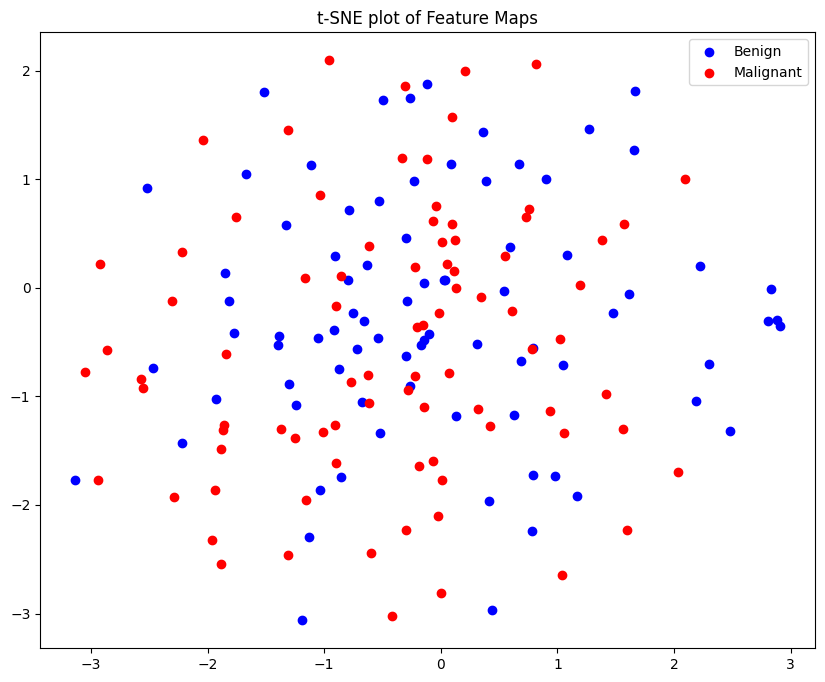

In [35]:
generate_tsne_plot(all_features, all_labels)

# End